# CYBERML - Projet 2025-2026
## Classification et Détection d'Anomalies pour le Suivi des Attaques Réseau

**Étudiant:** Robin De Bastos  
**Année:** 2025-2026 SCIA

Ce notebook implémente une chaîne complète de traitement de données pour la détection d'intrusions réseau en utilisant des données CICFlowMeter.

## Objectifs
- Classification supervisée (3 algorithmes)
- Détection d'anomalies non supervisée (3 algorithmes)
- Benchmark complet avec toutes les métriques requises


In [1]:

import sys
import os
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from data_loader import load_all_csv_files, label_data, balance_dataset
from data_exploration import *
from data_preparation import prepare_features_for_ml
from classification import ClassificationModels
from anomaly_detection import *
from evaluation import calculate_all_metrics, print_metrics_summary, compare_models
from visualization import *

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Tous les modules importés avec succès")


Tous les modules importés avec succès


## Phase 1 : Préparation et exploration des données

### Step 1.1 : Chargement et fusion des données


In [2]:
print("=" * 60)
print("Chargement des données CICFlowMeter (mode optimisé)")
print("=" * 60)

df_raw = load_all_csv_files(data_dir='../data', max_rows_per_attack_type=500000)
print(f"\n✓ Dataset brut chargé: {len(df_raw)} lignes, {len(df_raw.columns)} colonnes")

df = balance_dataset(df_raw, target_benign_ratio=0.5, balance_attack_types=True, random_state=42)

print(f"\n✓ Dataset équilibré final: {len(df)} lignes, {len(df.columns)} colonnes")


Chargement des données CICFlowMeter (mode optimisé)
Chargement des données (mode optimisé mémoire)...
  Chargement de 4 fichier(s) depuis Benign...
    → Répartition: 4 fichier(s) avec ~125,000 lignes chacun
    BenignTraffic2.pcap_Flow.csv: 91,279 lignes chargées
    BenignTraffic.pcap_Flow.csv: 125,000 lignes chargées
    BenignTraffic3.pcap_Flow.csv: 38,895 lignes chargées
    BenignTraffic1.pcap_Flow.csv: 84,526 lignes chargées
  Chargement de 1 fichier(s) depuis BruteForce...
    DictionaryBruteForce.pcap_Flow.csv: 3,619 lignes chargées
  Chargement de 61 fichier(s) depuis DDoS...
    → Répartition: 30 fichier(s) avec ~16,666 lignes chacun
    DDoS-HTTP_Flood-.pcap_Flow.csv: 16,666 lignes chargées
    DDoS-ACK_Fragmentation4.pcap_Flow.csv: 16,666 lignes chargées
    DDoS-ACK_Fragmentation.pcap_Flow.csv: 16,666 lignes chargées
    DDoS-ACK_Fragmentation2.pcap_Flow.csv: 16,666 lignes chargées
    DDoS-ACK_Fragmentation1.pcap_Flow.csv: 16,666 lignes chargées
    DDoS-ACK_Fragmentatio

### Step 1.2 : Labellisation automatique


In [3]:

df = label_data(df)

print("\nDistribution des classes:")
print(df['attack_type'].value_counts().sort_index())



Distribution des labels:
attack_type
Benign        339700
BruteForce      3619
DDoS           48528
DoS           130639
Mirai          48529
Recon          48528
Spoofing       48529
Web-Based      11328
Name: count, dtype: int64

Total Benign: 339700
Total Attacks: 339700

Distribution des classes:
attack_type
Benign        339700
BruteForce      3619
DDoS           48528
DoS           130639
Mirai          48529
Recon          48528
Spoofing       48529
Web-Based      11328
Name: count, dtype: int64


### Step 1.3 : Exploration et caractérisation du dataset


In [4]:

print("=" * 60)
print("Caractérisation du dataset")
print("=" * 60)

nb_dimensions = get_nb_of_dimensions(df)
nb_rows = get_nb_of_rows(df)
column_names = get_column_names(df)

print(f"\nNombre de dimensions (colonnes): {nb_dimensions}")
print(f"Nombre de lignes: {nb_rows}")
print(f"\nPremières colonnes: {column_names[:10]}")

numeric_cols = get_number_column_names(df)
categorical_cols = get_object_column_names(df)

print(f"\nColonnes numériques: {len(numeric_cols)}")
print(f"Colonnes catégorielles: {len(categorical_cols)}")
print(f"\nColonnes catégorielles: {categorical_cols}")


Caractérisation du dataset

Nombre de dimensions (colonnes): 87
Nombre de lignes: 679400

Premières colonnes: ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets']

Colonnes numériques: 80
Colonnes catégorielles: 7

Colonnes catégorielles: ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label', 'attack_type', 'attack_category']


In [5]:

print("\nTaux de valeurs NaN par colonne (top 20):")
nan_rates = get_nan_rates(df)
print(nan_rates.sort_values(ascending=False).head(20))

print("\n\nTaux de valeurs zéro pour les colonnes numériques (top 20):")
zero_rates = get_zero_rates(df, numeric_only=True)
print(zero_rates.sort_values(ascending=False).head(20))



Taux de valeurs NaN par colonne (top 20):
Flow Bytes/s                  0.412717
Src IP                        0.000000
Flow ID                       0.000000
Dst IP                        0.000000
Dst Port                      0.000000
Protocol                      0.000000
Src Port                      0.000000
Timestamp                     0.000000
Flow Duration                 0.000000
Total Bwd packets             0.000000
Total Fwd Packet              0.000000
Total Length of Bwd Packet    0.000000
Fwd Packet Length Max         0.000000
Fwd Packet Length Min         0.000000
Total Length of Fwd Packet    0.000000
Fwd Packet Length Mean        0.000000
Fwd Packet Length Std         0.000000
Bwd Packet Length Min         0.000000
Bwd Packet Length Max         0.000000
Bwd Packet Length Mean        0.000000
dtype: float64


Taux de valeurs zéro pour les colonnes numériques (top 20):
URG Flag Count           100.000000
Fwd Bulk Rate Avg        100.000000
Fwd Packet/Bulk Avg      100

### Step 1.4 : Visualisation initiale


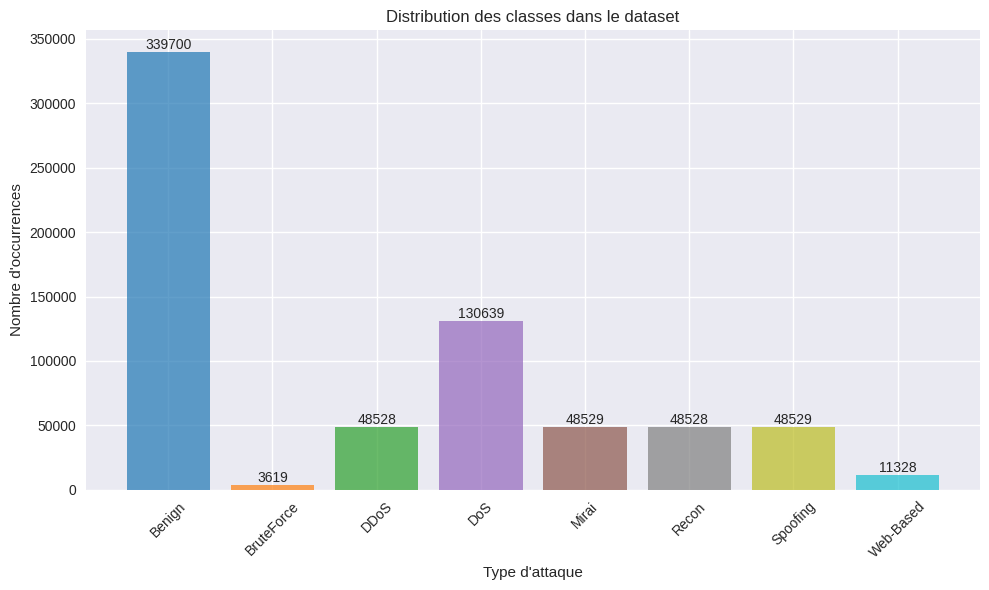

In [6]:
plot_class_distribution(df, label_col='attack_type')


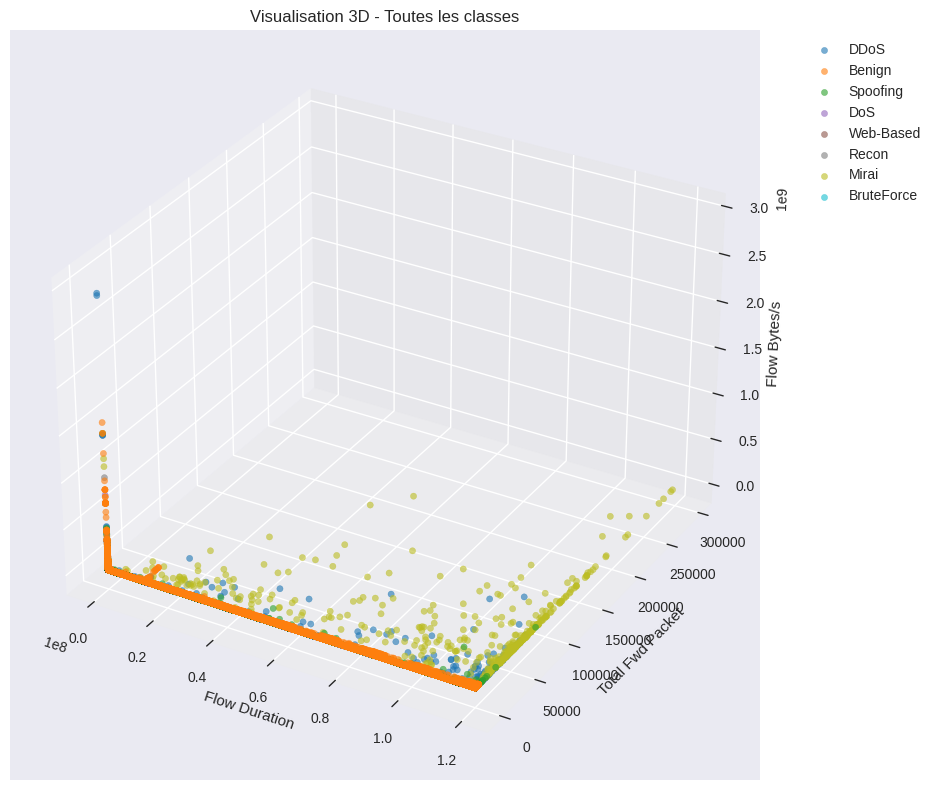

In [7]:
if 'Flow Duration' in df.columns and 'Total Fwd Packet' in df.columns and 'Flow Bytes/s' in df.columns:
    show3d_plot(df, 
                x_col='Flow Duration', 
                y_col='Total Fwd Packet', 
                z_col='Flow Bytes/s',
                label_col='attack_type',
                title='Visualisation 3D - Toutes les classes')


## Phase 2 : Préparation des données pour le ML

### Step 2.1 : Nettoyage des données


In [9]:
label_cols = ['attack_type', 'isAttack', 'attack_category', 'Label']
drop_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']

print("Préparation des features pour le ML...")
df_prepared = prepare_features_for_ml(df, label_columns=label_cols, drop_columns=drop_cols)

print(f"Features préparées: {len(df_prepared.columns)} colonnes")
print(f"Lignes: {len(df_prepared)}")

for col in label_cols:
    if col in df.columns:
        df_prepared[col] = df[col].values

print(f"\nVérification des NaN: {df_prepared.select_dtypes(include=[np.number]).isnull().sum().sum()} valeurs NaN restantes")


Préparation des features pour le ML...
Features préparées: 83 colonnes
Lignes: 679400

Vérification des NaN: 0 valeurs NaN restantes


### Step 2.2 : Feature engineering et Step 2.3 : Split train/test


In [10]:

feature_cols = [col for col in df_prepared.columns if col not in label_cols]
X = df_prepared[feature_cols]
y_binary = df_prepared['isAttack']
y_multiclass = df_prepared['attack_category']

print(f"Nombre de features: {len(feature_cols)}")
print(f"Nombre d'échantillons: {len(X)}")


X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)


X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

print(f"\nSplit train/test effectué (80/20)")
print(f"  Train: {len(X_train_bin)} échantillons")
print(f"  Test: {len(X_test_bin)} échantillons")


Nombre de features: 79
Nombre d'échantillons: 679400

Split train/test effectué (80/20)
  Train: 543520 échantillons
  Test: 135880 échantillons


## Phase 3 : Benchmark - Classification supervisée (3 algorithmes)

### Step 3.1-3.2 : Classification binaire (Benign vs Attack)


In [11]:
clf_models = ClassificationModels()
binary_metrics = {}

In [12]:
print("\n1. Entraînement XGBoost...")
xgb_model = clf_models.train_xgboost(
    X_train_bin, y_train_bin, 
    X_test_bin, y_test_bin,
    n_estimators=100,
    max_depth=6
)

y_pred_xgb, y_proba_xgb = clf_models.predict('XGBoost', X_test_bin, return_proba=True)
metrics_xgb = calculate_all_metrics(y_test_bin, y_pred_xgb, y_proba_xgb, average='binary')
binary_metrics['XGBoost'] = metrics_xgb
print_metrics_summary(metrics_xgb, "XGBoost")



1. Entraînement XGBoost...

Métriques pour XGBoost

Confusion Matrix:
[[64130  3810]
 [14787 53153]]

Métriques principales:
  Precision:     0.9331
  Recall:        0.7824
  F1-Score:      0.8511
  Accuracy:      0.8631
  Balanced Acc:  0.8631
  MCC:           0.7359
  AUPRC:         0.9469
  ROC-AUC:       0.9328



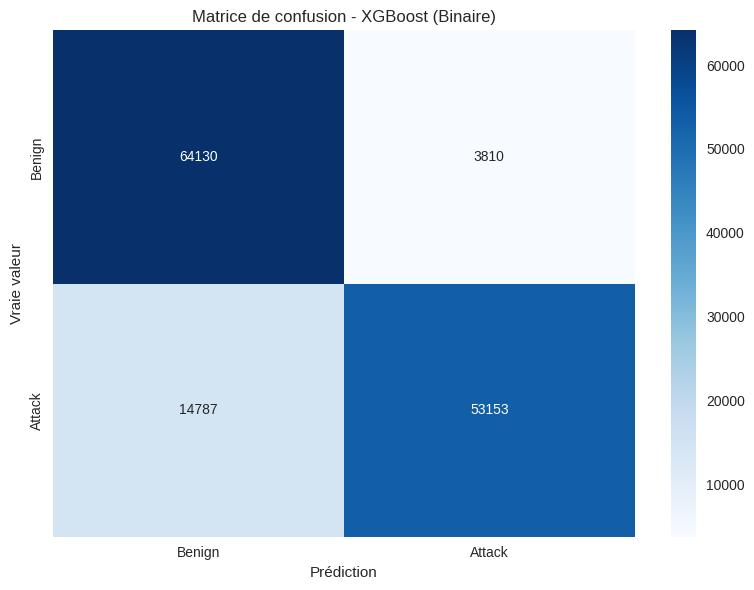

In [14]:
plot_confusion_matrix(metrics_xgb['confusion_matrix'], 
                     class_names=['Benign', 'Attack'],
                     title='Matrice de confusion - XGBoost (Binaire)')

In [15]:
print("\n2. Entraînement Random Forest...")
rf_model = clf_models.train_random_forest(
    X_train_bin, y_train_bin,
    n_estimators=100,
    max_depth=20
)

y_pred_rf, y_proba_rf = clf_models.predict('RandomForest', X_test_bin, return_proba=True)
metrics_rf = calculate_all_metrics(y_test_bin, y_pred_rf, y_proba_rf, average='binary')
binary_metrics['RandomForest'] = metrics_rf
print_metrics_summary(metrics_rf, "Random Forest")



2. Entraînement Random Forest...

Métriques pour Random Forest

Confusion Matrix:
[[65486  2454]
 [11733 56207]]

Métriques principales:
  Precision:     0.9582
  Recall:        0.8273
  F1-Score:      0.8879
  Accuracy:      0.8956
  Balanced Acc:  0.8956
  MCC:           0.7987
  AUPRC:         0.9657
  ROC-AUC:       0.9567



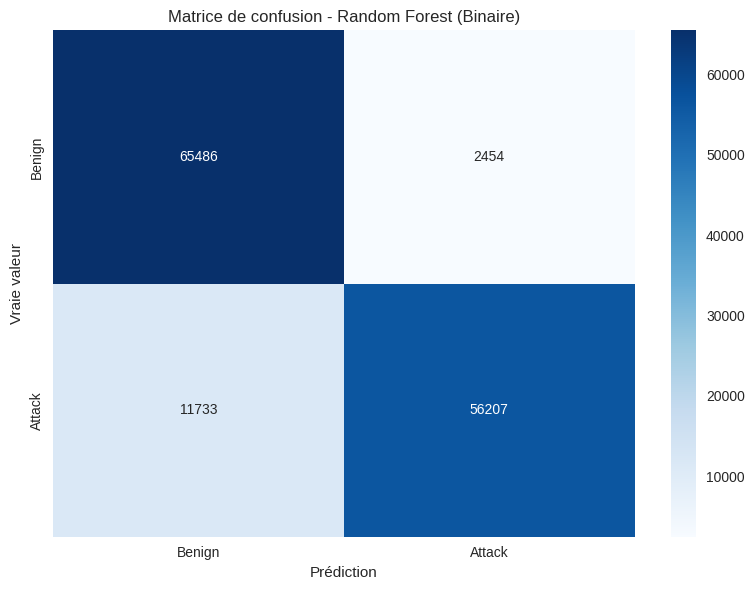

In [16]:
# Visualisation de la matrice de confusion - Random Forest (Binaire)
plot_confusion_matrix(metrics_rf['confusion_matrix'], 
                     class_names=['Benign', 'Attack'],
                     title='Matrice de confusion - Random Forest (Binaire)')

In [17]:
print("\n3. Entraînement SVM (LinearSVC)...")
svm_model = clf_models.train_svm(
    X_train_bin, y_train_bin,
    scale=True,
    C=1.0
)

y_pred_svm, y_proba_svm = clf_models.predict('SVM', X_test_bin, return_proba=True)
metrics_svm = calculate_all_metrics(y_test_bin, y_pred_svm, y_proba_svm, average='binary')
binary_metrics['SVM'] = metrics_svm
print_metrics_summary(metrics_svm, "SVM")



3. Entraînement SVM (LinearSVC)...

Métriques pour SVM

Confusion Matrix:
[[59019  8921]
 [33696 34244]]

Métriques principales:
  Precision:     0.7933
  Recall:        0.5040
  F1-Score:      0.6164
  Accuracy:      0.6864
  Balanced Acc:  0.6864
  MCC:           0.4003
  AUPRC:         0.8163
  ROC-AUC:       0.7766



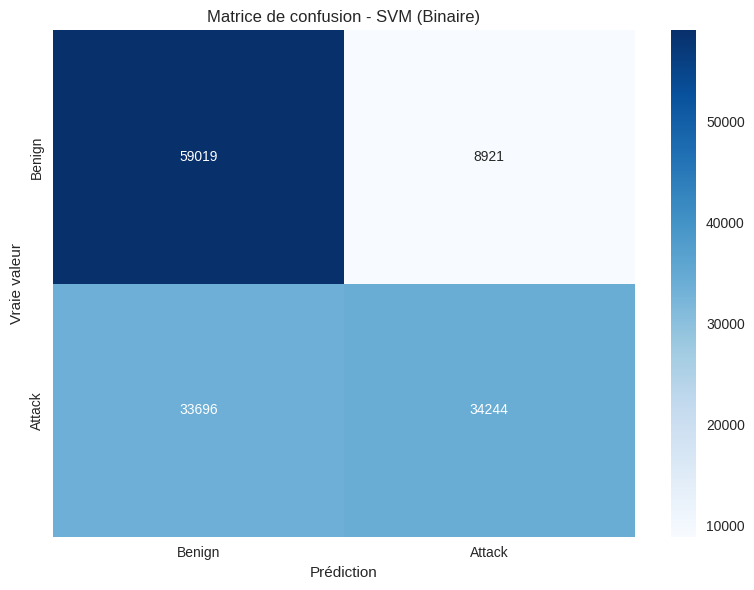

In [18]:
# Visualisation de la matrice de confusion - SVM (Binaire)
plot_confusion_matrix(metrics_svm['confusion_matrix'], 
                     class_names=['Benign', 'Attack'],
                     title='Matrice de confusion - SVM (Binaire)')

### Step 3.3 : Classification multi-classes (8 classes)


In [19]:
import importlib
import classification
import evaluation
importlib.reload(classification)
importlib.reload(evaluation)
from classification import ClassificationModels
from evaluation import calculate_all_metrics

clf_models_multi = ClassificationModels()
print("Modules rechargés")

Modules rechargés


In [20]:
multiclass_metrics = {}
clf_models_multi = ClassificationModels()

In [23]:
print("\n1. Entraînement XGBoost (multi-classes)...")
xgb_multi = clf_models_multi.train_xgboost(
    X_train_multi, y_train_multi,
    X_test_multi, y_test_multi,
    n_estimators=100,
    max_depth=6
)

y_pred_xgb_multi, y_proba_xgb_multi = clf_models_multi.predict('XGBoost', X_test_multi, return_proba=True)
metrics_xgb_multi = calculate_all_metrics(
    y_test_multi, y_pred_xgb_multi, y_proba_xgb_multi, average='macro'
)
multiclass_metrics['XGBoost'] = metrics_xgb_multi
print_metrics_summary(metrics_xgb_multi, "XGBoost (Multi-classes)")

class_names_multi = sorted(y_test_multi.unique())



1. Entraînement XGBoost (multi-classes)...

Métriques pour XGBoost (Multi-classes)

Confusion Matrix:
[[66821     0    35   214   542   214    79    35]
 [  518    68     1     3    13     3   117     1]
 [ 2560     2  5384   368   963   236   166    26]
 [ 2178     0   100 22437   619   627   141    26]
 [ 3300     2   175   309  5654    16   250     0]
 [ 4511     1    11   403    72  4408   238    61]
 [ 5200     1    25    98   239    39  4103     1]
 [ 1328     1     1    37    17    47   131   704]]

Métriques principales:
  Precision:     0.8317
  Recall:        0.5326
  F1-Score:      0.6053
  Accuracy:      0.8064
  Balanced Acc:  0.5326
  MCC:           0.7117
  AUPRC:         0.6740
  ROC-AUC:       0.9403



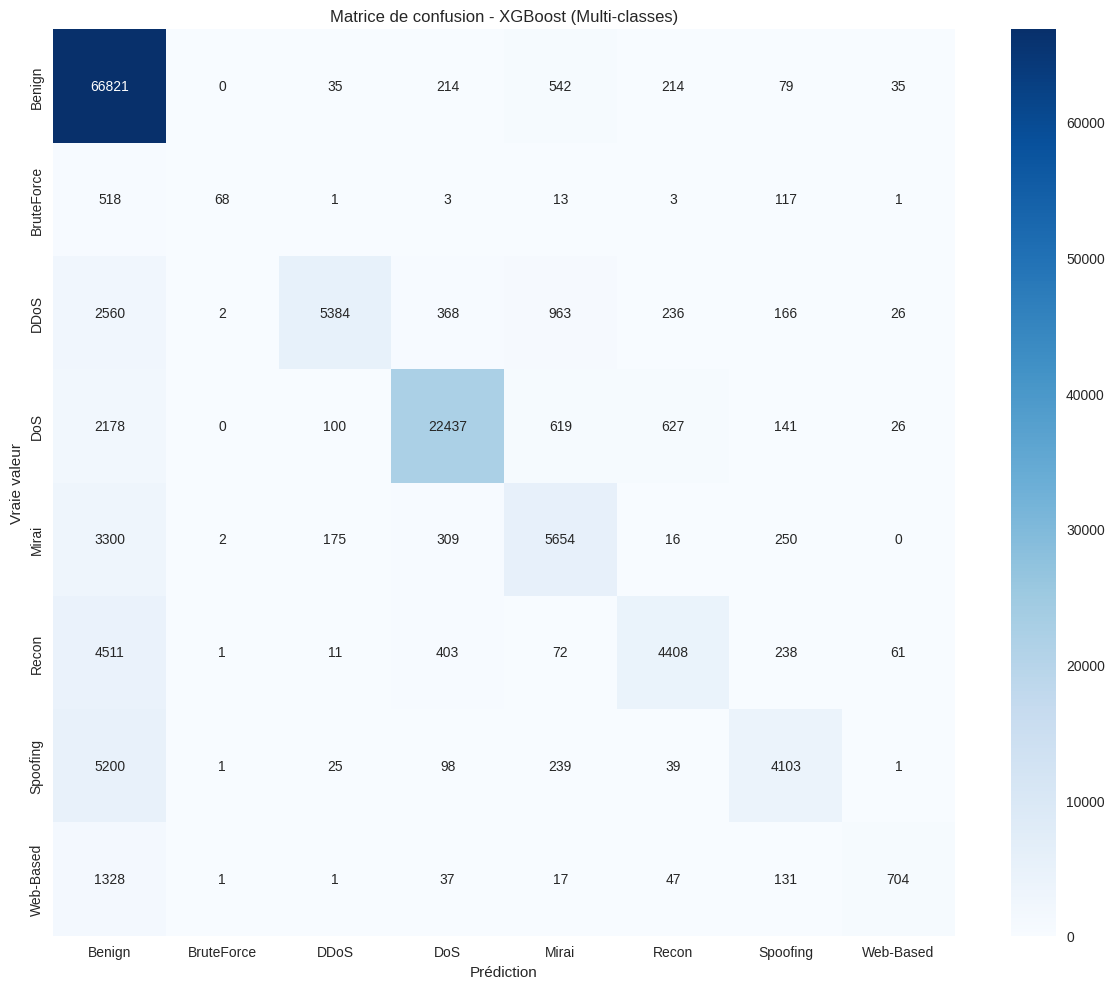

In [24]:
# Visualisation de la matrice de confusion - XGBoost (Multi-classes)
plot_confusion_matrix(metrics_xgb_multi['confusion_matrix'], 
                     class_names=class_names_multi,
                     figsize=(12, 10),
                     title='Matrice de confusion - XGBoost (Multi-classes)')

In [25]:
print("\n2. Entraînement Random Forest (multi-classes)...")
rf_multi = clf_models_multi.train_random_forest(
    X_train_multi, y_train_multi,
    n_estimators=100,
    max_depth=20
)

y_pred_rf_multi, y_proba_rf_multi = clf_models_multi.predict('RandomForest', X_test_multi, return_proba=True)
metrics_rf_multi = calculate_all_metrics(
    y_test_multi, y_pred_rf_multi, y_proba_rf_multi, average='macro'
)
multiclass_metrics['RandomForest'] = metrics_rf_multi
print_metrics_summary(metrics_rf_multi, "Random Forest (Multi-classes)")



2. Entraînement Random Forest (multi-classes)...

Métriques pour Random Forest (Multi-classes)

Confusion Matrix:
[[66921    29    47   185   368   163   154    73]
 [  384   113     1     4    12     9   191    10]
 [ 1881     2  5912   328  1143   207   181    51]
 [ 1656     2   167 22852   640   567   178    66]
 [ 2154     2   327   293  6558    26   336    10]
 [ 4008    10    33   282    73  4996   204    99]
 [ 4052    18    38   117   249    78  5128    26]
 [ 1055    17     5    31    23    55   202   878]]

Métriques principales:
  Precision:     0.7876
  Recall:        0.5914
  F1-Score:      0.6553
  Accuracy:      0.8343
  Balanced Acc:  0.5914
  MCC:           0.7543
  AUPRC:         0.7241
  ROC-AUC:       0.9585



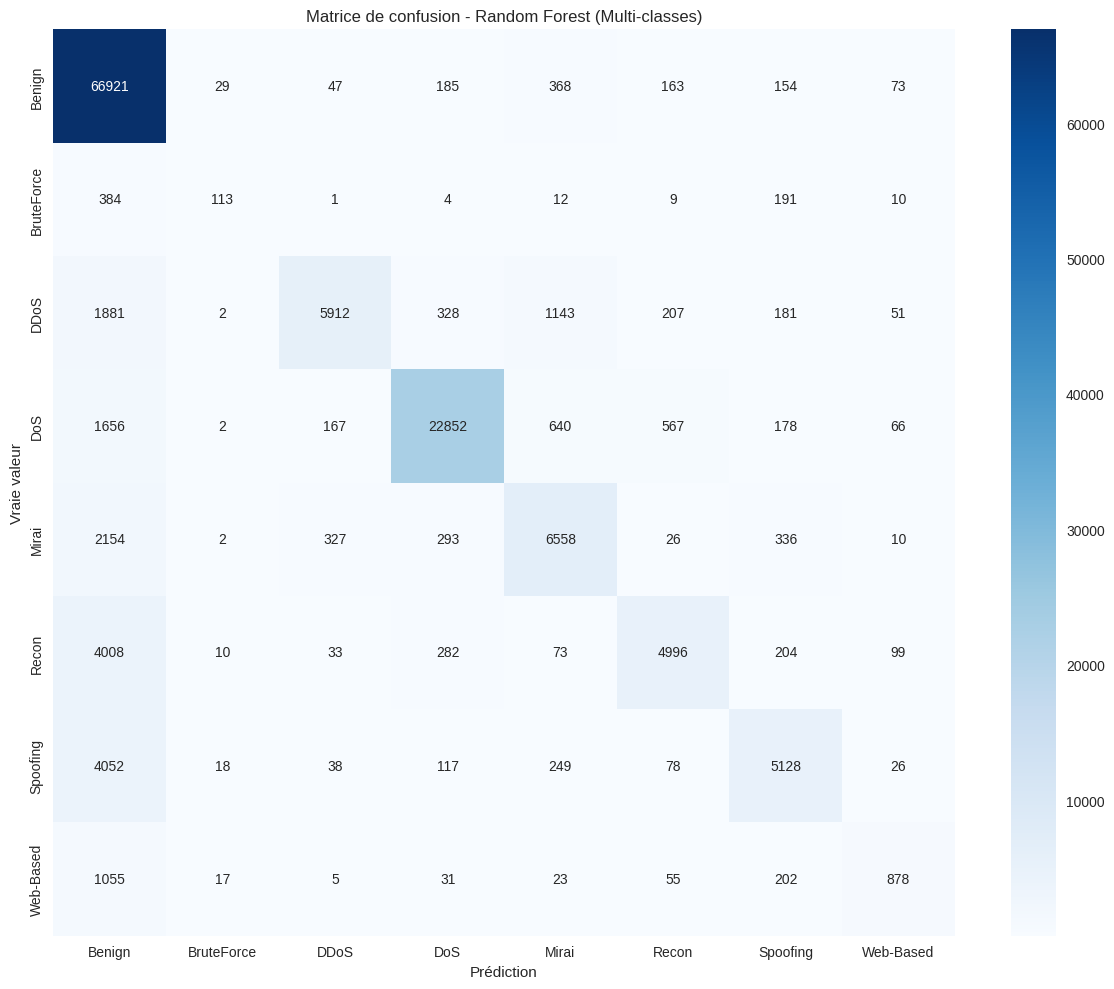

In [26]:
# Visualisation de la matrice de confusion - Random Forest (Multi-classes)
plot_confusion_matrix(metrics_rf_multi['confusion_matrix'], 
                     class_names=class_names_multi,
                     figsize=(12, 10),
                     title='Matrice de confusion - Random Forest (Multi-classes)')

In [27]:
print("\n3. Entraînement SVM (multi-classes, LinearSVC)...")
svm_multi = clf_models_multi.train_svm(
    X_train_multi, y_train_multi,
    scale=True,
    C=0.1,
    max_iter=500,
    dual=False,
    tol=1e-2  
)
y_pred_svm_multi, y_proba_svm_multi = clf_models_multi.predict('SVM', X_test_multi, return_proba=True)
metrics_svm_multi = calculate_all_metrics(
    y_test_multi, y_pred_svm_multi, y_proba_svm_multi, average='macro'
)
multiclass_metrics['SVM'] = metrics_svm_multi
print_metrics_summary(metrics_svm_multi, "SVM (Multi-classes)")



3. Entraînement SVM (multi-classes, LinearSVC)...

Métriques pour SVM (Multi-classes)

Confusion Matrix:
[[66337     0    16  1482    49     0    56     0]
 [  708     0     0    15     0     0     1     0]
 [ 4477     0  4207   924    92     0     5     0]
 [ 6459     0   171 19411    66     2    19     0]
 [ 8410     0    61  1005   222     0     8     0]
 [ 8178     0     1  1506    15     1     4     0]
 [ 8952     0     8   571    14     0   161     0]
 [ 2244     0     0    19     0     0     3     0]]

Métriques principales:
  Precision:     0.4741
  Recall:        0.2740
  F1-Score:      0.2743
  Accuracy:      0.6648
  Balanced Acc:  0.2740
  MCC:           0.4764
  AUPRC:         0.3470
  ROC-AUC:       0.7715



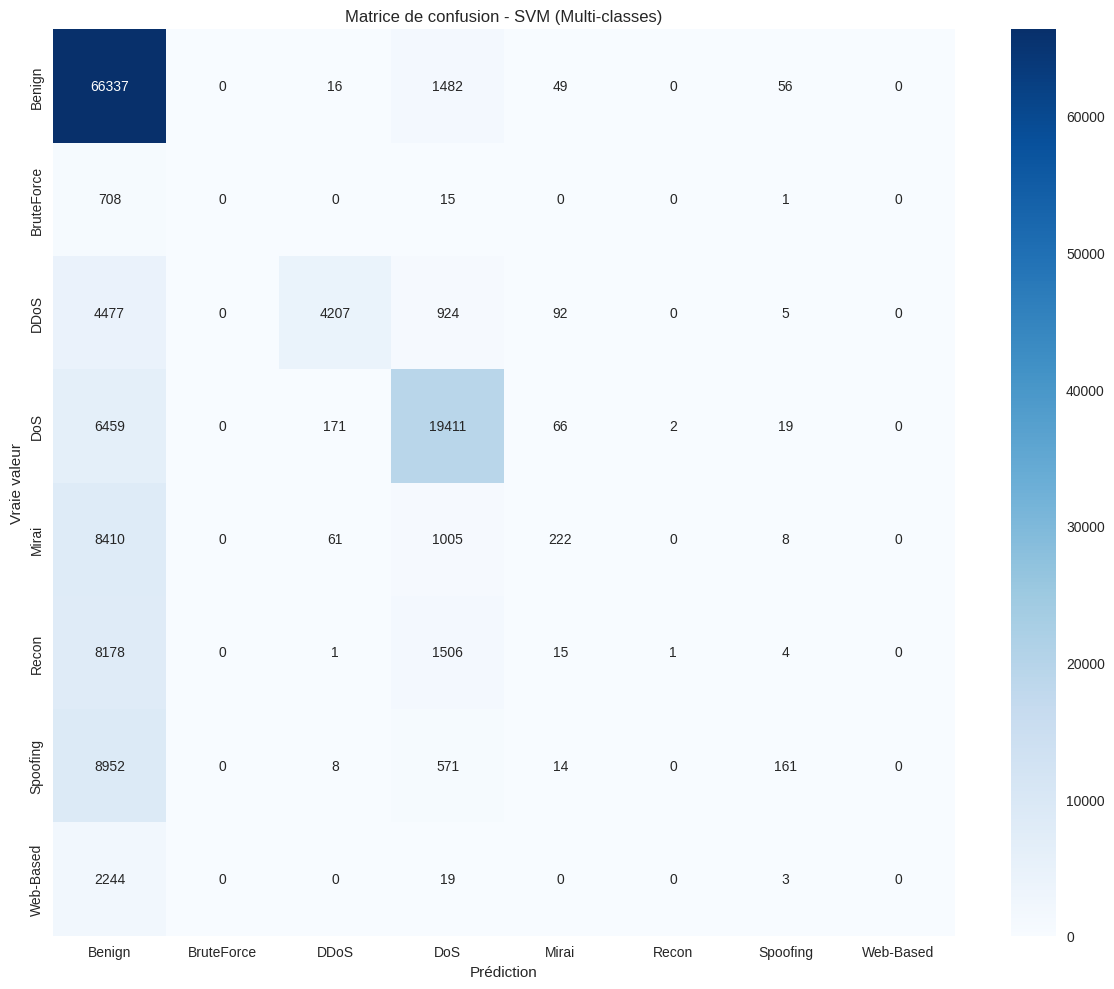

In [28]:
# Visualisation de la matrice de confusion - SVM (Multi-classes)
plot_confusion_matrix(metrics_svm_multi['confusion_matrix'], 
                     class_names=class_names_multi,
                     figsize=(12, 10),
                     title='Matrice de confusion - SVM (Multi-classes)')

### Step 3.4 : Analyse comparative des classifieurs



COMPARAISON DES MODÈLES - CLASSIFICATION BINAIRE
          Model  Precision    Recall  F1-Score  Accuracy  Balanced Accuracy  \
0       XGBoost   0.933114  0.782352  0.851108  0.863137           0.863137   
1  RandomForest   0.958166  0.827304  0.887939  0.895592           0.895592   
2           SVM   0.793328  0.504033  0.616426  0.686363           0.686363   

        MCC     AUPRC   ROC-AUC  
0  0.735942  0.946894  0.932804  
1  0.798667  0.965656  0.956702  
2  0.400290  0.816298  0.776625  


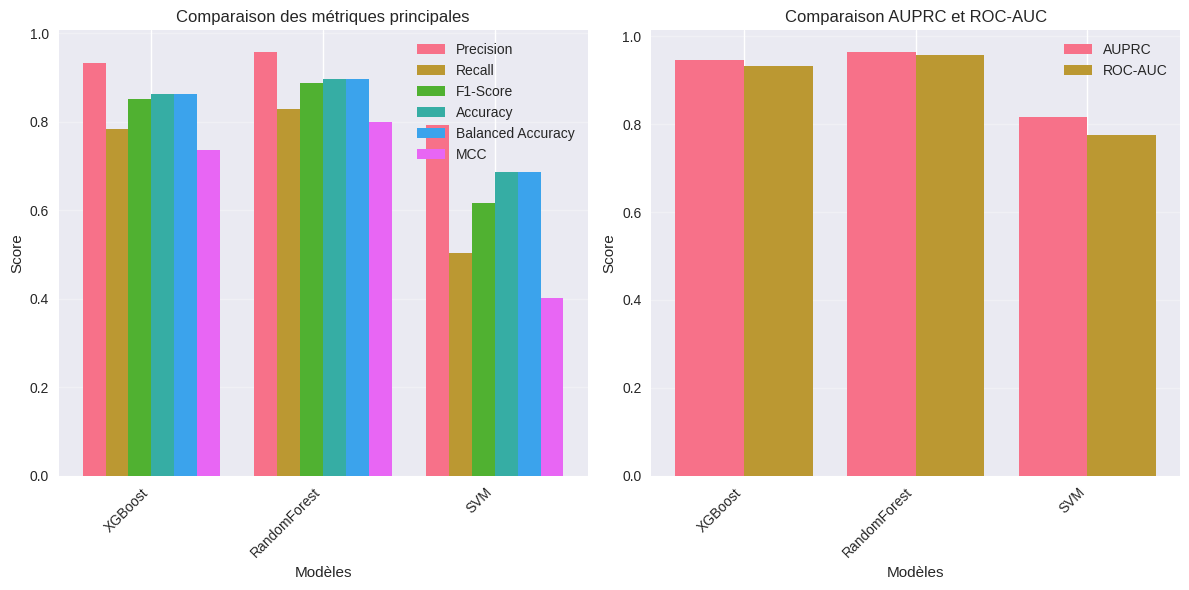

In [29]:
print("\n" + "=" * 60)
print("COMPARAISON DES MODÈLES - CLASSIFICATION BINAIRE")
print("=" * 60)

comparison_binary = compare_models(binary_metrics)
print(comparison_binary)

plot_metrics_comparison(comparison_binary)



COMPARAISON DES MODÈLES - CLASSIFICATION MULTI-CLASSES
          Model  Precision    Recall  F1-Score  Accuracy  Balanced Accuracy  \
0       XGBoost   0.831721  0.532636  0.605345  0.806440           0.532636   
1  RandomForest   0.787563  0.591390  0.655299  0.834251           0.591390   
2           SVM   0.474084  0.274047  0.274267  0.664844           0.274047   

        MCC     AUPRC   ROC-AUC  
0  0.711697  0.673959  0.940300  
1  0.754325  0.724133  0.958453  
2  0.476448  0.347025  0.771544  


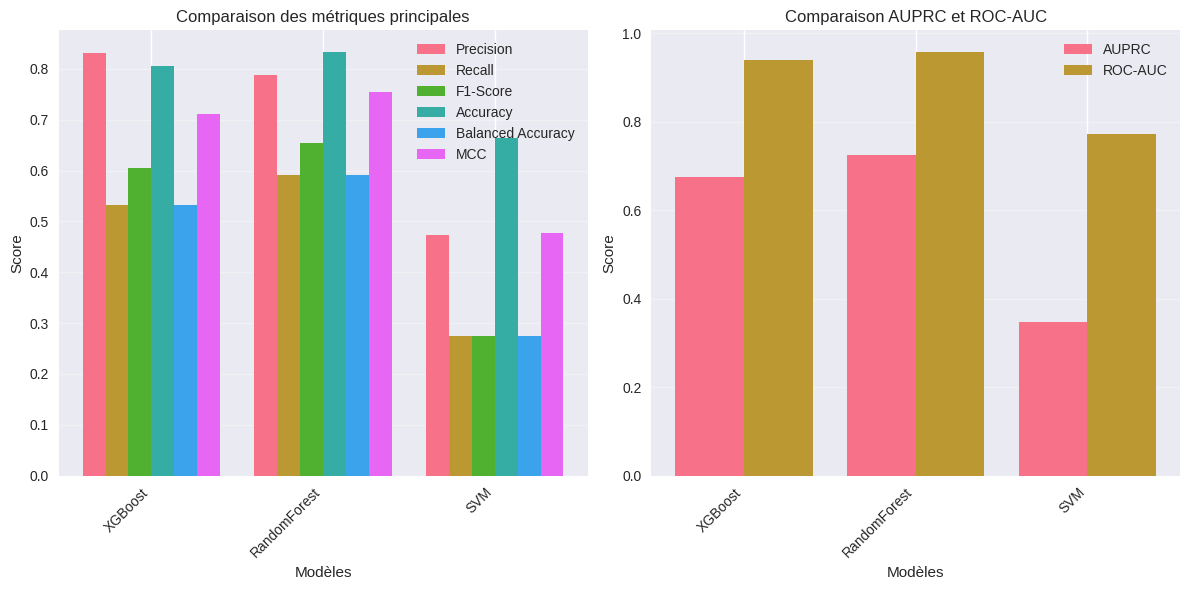

In [30]:
print("\n" + "=" * 60)
print("COMPARAISON DES MODÈLES - CLASSIFICATION MULTI-CLASSES")
print("=" * 60)

comparison_multiclass = compare_models(multiclass_metrics)
print(comparison_multiclass)

plot_metrics_comparison(comparison_multiclass)


## Phase 4 : Benchmark - Détection d'anomalies non supervisée (3 algorithmes)

### Step 4.1-4.4 : Détection d'anomalies avec les 3 algorithmes


In [31]:

df_anomaly = df_prepared.copy()

contamination_rate = (df_anomaly['isAttack'] == 1).sum() / len(df_anomaly)
print(f"Taux de contamination estimé: {contamination_rate:.4f}")

print("=" * 60)
print("DÉTECTION D'ANOMALIES NON SUPERVISÉE")
print("=" * 60)


Taux de contamination estimé: 0.5000
DÉTECTION D'ANOMALIES NON SUPERVISÉE


In [32]:
print("\n1. Isolation Forest...")
if_predictions = get_isolation_forest_outliers(
    df_anomaly, 
    contamination=contamination_rate,
    random_state=42
)

df_anomaly['if_outliers'] = if_predictions
if_metrics = evaluate_anomaly_detection(df_anomaly['isAttack'], if_predictions)

print(f"  Outliers détectés: {(if_predictions == -1).sum()}")
print(f"  Precision: {if_metrics['precision']:.4f}")
print(f"  Recall: {if_metrics['recall']:.4f}")
print(f"  F1-Score: {if_metrics['f1_score']:.4f}")
print(f"  Taux de détection: {if_metrics['detection_rate']:.4f}")
print(f"  Taux de faux positifs: {if_metrics['false_positive_rate']:.4f}")



1. Isolation Forest...
  Outliers détectés: 339685
  Precision: 0.5190
  Recall: 0.5190
  F1-Score: 0.5190
  Taux de détection: 0.5190
  Taux de faux positifs: 0.4809


In [33]:
print("\n2. Local Outlier Factor (LOF)...")
lof_predictions = get_lof_outliers(
    df_anomaly,
    contamination=contamination_rate
)

df_anomaly['lof_outliers'] = lof_predictions
lof_metrics = evaluate_anomaly_detection(df_anomaly['isAttack'], lof_predictions)

print(f"  Outliers détectés: {(lof_predictions == -1).sum()}")
print(f"  Precision: {lof_metrics['precision']:.4f}")
print(f"  Recall: {lof_metrics['recall']:.4f}")
print(f"  F1-Score: {lof_metrics['f1_score']:.4f}")
print(f"  Taux de détection: {lof_metrics['detection_rate']:.4f}")
print(f"  Taux de faux positifs: {lof_metrics['false_positive_rate']:.4f}")



2. Local Outlier Factor (LOF)...
  Outliers détectés: 339700
  Precision: 0.5187
  Recall: 0.5187
  F1-Score: 0.5187
  Taux de détection: 0.5187
  Taux de faux positifs: 0.4813


In [34]:
print("\n3. Elliptic Envelope...")
ee_predictions = get_elliptic_envelope_outliers(
    df_anomaly,
    contamination=contamination_rate,
    random_state=42
)

df_anomaly['ee_outliers'] = ee_predictions
ee_metrics = evaluate_anomaly_detection(df_anomaly['isAttack'], ee_predictions)

print(f"  Outliers détectés: {(ee_predictions == -1).sum()}")
print(f"  Precision: {ee_metrics['precision']:.4f}")
print(f"  Recall: {ee_metrics['recall']:.4f}")
print(f"  F1-Score: {ee_metrics['f1_score']:.4f}")
print(f"  Taux de détection: {ee_metrics['detection_rate']:.4f}")
print(f"  Taux de faux positifs: {ee_metrics['false_positive_rate']:.4f}")



3. Elliptic Envelope...
  Outliers détectés: 339700
  Precision: 0.5370
  Recall: 0.5370
  F1-Score: 0.5370
  Taux de détection: 0.5370
  Taux de faux positifs: 0.4630


### Step 4.5-4.6 : Évaluation et analyse comparative


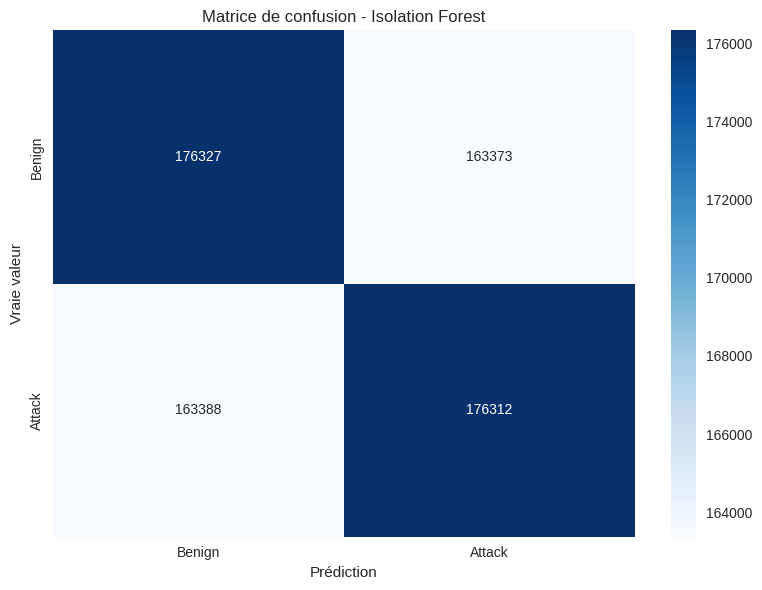

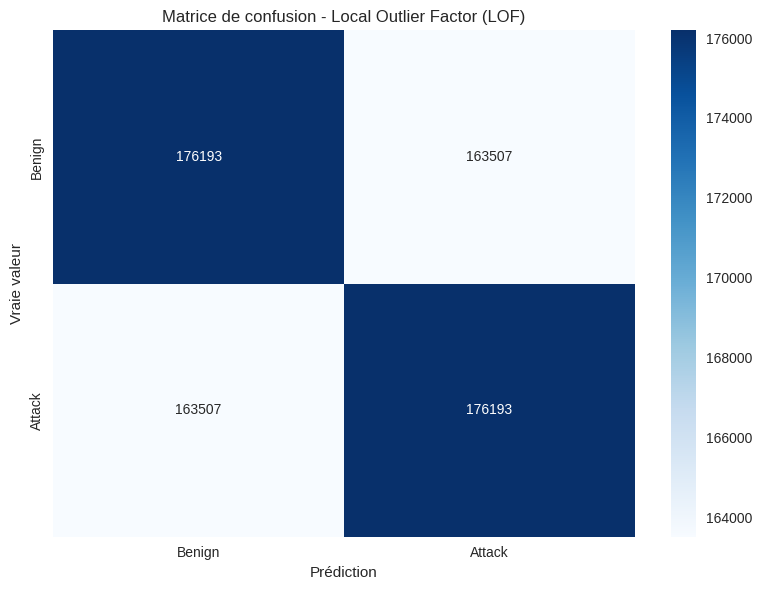

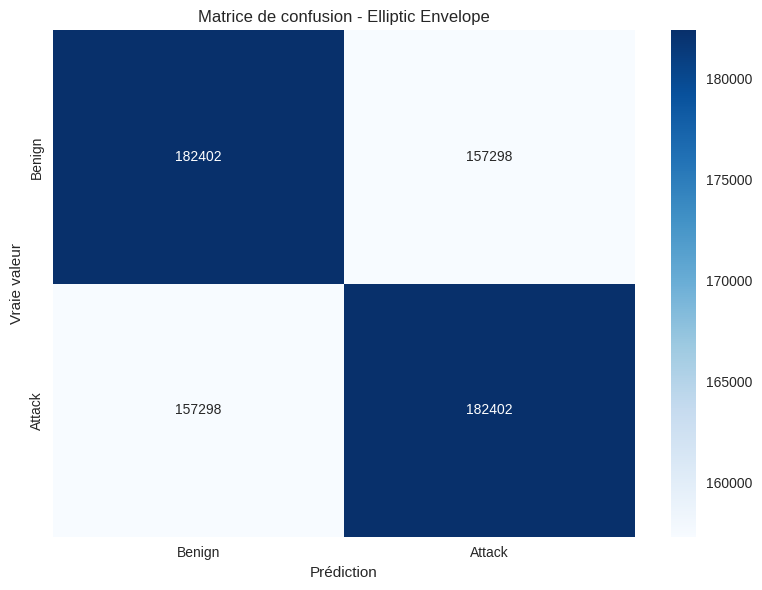

In [38]:
from sklearn.metrics import confusion_matrix

y_pred_if_binary = (if_predictions == -1).astype(int)
cm_if = confusion_matrix(df_anomaly['isAttack'], y_pred_if_binary)

plot_confusion_matrix(cm_if, 
                     class_names=['Benign', 'Attack'],
                     title='Matrice de confusion - Isolation Forest')

y_pred_lof_binary = (lof_predictions == -1).astype(int)
cm_lof = confusion_matrix(df_anomaly['isAttack'], y_pred_lof_binary)

plot_confusion_matrix(cm_lof, 
                     class_names=['Benign', 'Attack'],
                     title='Matrice de confusion - Local Outlier Factor (LOF)')

y_pred_ee_binary = (ee_predictions == -1).astype(int)
cm_ee = confusion_matrix(df_anomaly['isAttack'], y_pred_ee_binary)

plot_confusion_matrix(cm_ee, 
                     class_names=['Benign', 'Attack'],
                     title='Matrice de confusion - Elliptic Envelope')


COMPARAISON DES DÉTECTEURS D'ANOMALIES
              Model  Precision    Recall  F1-Score  Detection Rate  \
0  Isolation Forest   0.519046  0.519023  0.519034        0.519023   
1               LOF   0.518672  0.518672  0.518672        0.518672   
2     One-Class SVM   0.536950  0.536950  0.536950        0.536950   

   False Positive Rate  
0             0.480933  
1             0.481328  
2             0.463050  


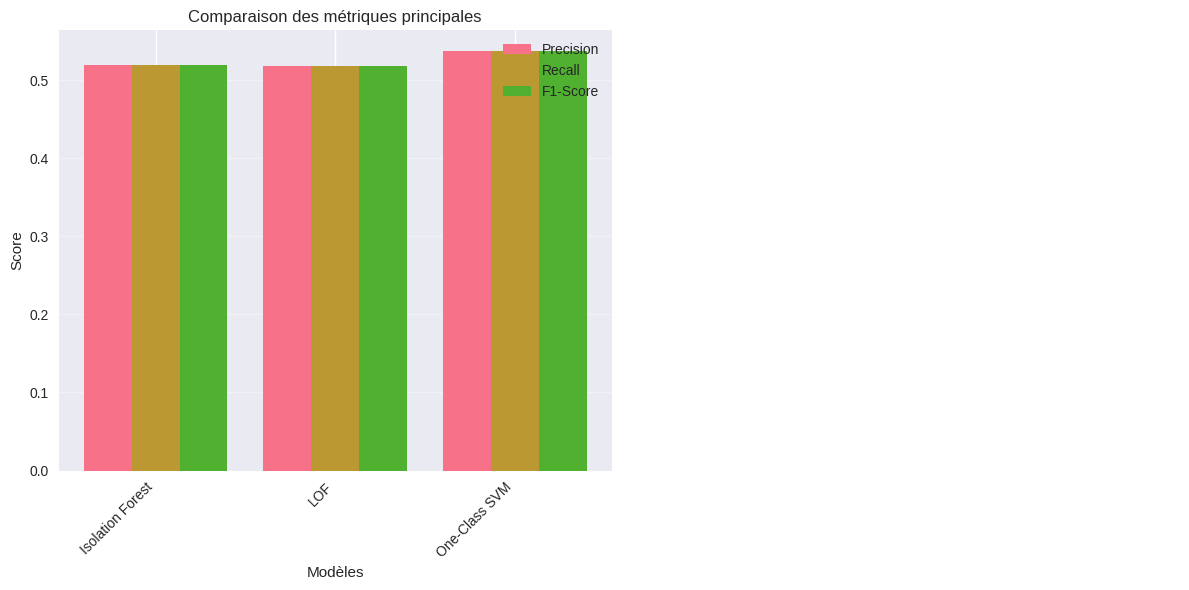

In [39]:
print("\n" + "=" * 60)
print("COMPARAISON DES DÉTECTEURS D'ANOMALIES")
print("=" * 60)

anomaly_comparison = pd.DataFrame({
    'Model': ['Isolation Forest', 'LOF', 'One-Class SVM'],
    'Precision': [if_metrics['precision'], lof_metrics['precision'], ee_metrics['precision']],
    'Recall': [if_metrics['recall'], lof_metrics['recall'], ee_metrics['recall']],
    'F1-Score': [if_metrics['f1_score'], lof_metrics['f1_score'], ee_metrics['f1_score']],
    'Detection Rate': [if_metrics['detection_rate'], lof_metrics['detection_rate'], ee_metrics['detection_rate']],
    'False Positive Rate': [if_metrics['false_positive_rate'], lof_metrics['false_positive_rate'], ee_metrics['false_positive_rate']]
})

print(anomaly_comparison)

plot_metrics_comparison(anomaly_comparison.rename(columns={'Detection Rate': 'Detection_Rate', 'False Positive Rate': 'False_Positive_Rate'}))


## Phase 5 : Analyse et conclusions

### Step 5.1 : Comparaison globale des approches


In [40]:
print("=" * 60)
print("COMPARAISON GLOBALE - SUPERVISÉ vs NON SUPERVISÉ")
print("=" * 60)

print("\nMeilleur modèle de classification (binaire):")
best_binary = comparison_binary.loc[comparison_binary['Balanced Accuracy'].idxmax()]
print(best_binary)

print("\nMeilleur détecteur d'anomalies:")
best_anomaly = anomaly_comparison.loc[anomaly_comparison['F1-Score'].idxmax()]
print(best_anomaly)

print("\nAnalyse complète terminée!")


COMPARAISON GLOBALE - SUPERVISÉ vs NON SUPERVISÉ

Meilleur modèle de classification (binaire):
Model                RandomForest
Precision                0.958166
Recall                   0.827304
F1-Score                 0.887939
Accuracy                 0.895592
Balanced Accuracy        0.895592
MCC                      0.798667
AUPRC                    0.965656
ROC-AUC                  0.956702
Name: 1, dtype: object

Meilleur détecteur d'anomalies:
Model                  One-Class SVM
Precision                    0.53695
Recall                       0.53695
F1-Score                     0.53695
Detection Rate               0.53695
False Positive Rate          0.46305
Name: 2, dtype: object

Analyse complète terminée!
